### Setup

In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import recall_score
import torch
#from imblearn.over_sampling import SMOTE

In [5]:
# Check if Cuda is running
torch.cuda.get_device_name(0)

'Quadro P5000'

In [22]:
data = pd.read_csv("creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [23]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
124011,77147.0,-1.437314,-0.672735,0.925002,-0.728117,-0.498919,-1.088232,0.098312,0.294362,-1.763211,...,-0.032172,-0.254662,0.569343,0.599137,-0.909906,0.070153,0.017838,0.001861,149.20,0
182926,125586.0,-1.188026,0.648003,0.195708,-2.300317,-1.876858,0.483442,-0.257970,-4.314653,1.394378,...,3.773234,-1.129681,-1.190132,0.066215,0.806729,0.669240,0.580496,0.090244,392.00,0
2807,2364.0,1.571567,-0.852696,-0.411170,-1.735533,-0.574247,-0.298426,-0.606201,-0.165091,-2.384797,...,-0.546954,-1.269700,0.009546,-0.896239,0.433003,-0.425964,0.000977,-0.003500,19.75,0
10848,18552.0,-0.265284,0.081207,1.595559,-1.671107,-0.359368,-0.158713,-0.188054,0.271057,2.710338,...,0.102560,0.673973,0.126516,-0.065758,-1.159539,-1.066871,0.283226,0.230268,11.85,0
250966,155148.0,-1.071928,0.594211,-0.352817,-0.819417,1.439513,0.755137,0.594540,0.448423,0.063034,...,-0.085680,0.088365,0.361190,-0.336159,-1.006584,0.176926,-0.098098,0.001136,14.75,0


In [24]:
data.ndim

2

### Data Analysis

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.174225e-15,3.429687e-16,-1.386421e-15,2.073779e-15,9.939598e-16,1.493625e-15,-5.931037e-16,1.318317e-16,-2.414318e-15,...,1.416845e-16,-3.515296e-16,2.727492e-16,4.482012e-15,5.203181e-16,1.689590e-15,-3.712632e-16,-1.159267e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

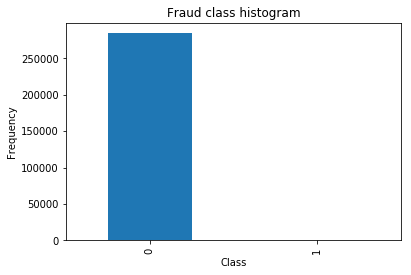

In [8]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [9]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

## 1. Run with Normalising data

In [10]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [11]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [12]:
# Normalising the training data and test data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [13]:
# Fit classifier to a model
classifier = RandomForestClassifier()
classifier.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_normalized)

In [15]:
# Making a Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85287,     4],
       [   45,   107]])

In [16]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85291
          1       0.96      0.70      0.81       152

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999427
Area under the curve : 0.851950


## 2. Run with Over Sampling data using SMOTE (Synthetic Minority Over-sampling Technique)

In [17]:
data2 = pd.read_csv("creditcard.csv")

In [18]:
from sklearn.preprocessing import StandardScaler

data2['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data2 = data2.drop(['Time','Amount'],axis=1)
data2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.349671
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.349231
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.127897
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.053373
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.221892


In [19]:
X = np.array(data.ix[:, data.columns != 'Class'])
y = np.array(data.ix[:, data.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 30)
Shape of y: (284807, 1)


In [20]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [21]:
# Over Sampling data using SMOTE
smote = SMOTE(random_state=2)
X_train_resample, y_train_resample = smote.fit_sample(X_train, y_train.ravel())

In [22]:
classifier = RandomForestClassifier()
classifier.fit(X_train_resample, y_train_resample.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [24]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85274,    17],
       [   26,   126]])

In [25]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85291
          1       0.88      0.83      0.85       152

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999497
Area under the curve : 0.914374


## 3. Run with DCGANs

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

# Custom DataLoader
class FraudDataset(Dataset):
    
    # Initialize the data
    def __init__(self):
        data = pd.read_csv("creditcard.csv")
        data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
        data = data.drop(['Time','Amount'],axis=1)
        
        # Rearrange columns to the right order
        cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
        'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normAmount', 'Class']
        data = data[cols]
        
        fraud_data = data.loc[data['Class']==1]
        self.len = fraud_data.shape[0]
        
        self.fraud_data = torch.FloatTensor(np.array(fraud_data))
        
        #self.X = np.array(data.loc[:, data.columns != 'Class'])
        #self.y = np.array(data.loc[:, data.columns == 'Class'])
        
        #self.X = torch.FloatTensor(self.X)
        #self.y = torch.FloatTensor(self.y)
        
    def __getitem__(self, index):
        return self.fraud_data[index]
    
    def __len__(self):
        return self.len

In [3]:
dataset = FraudDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=5,
                          shuffle=True,
                          num_workers=0)

In [4]:
# Generator's paragrams
g_input_size = 30     # Random noise dimension
g_hidden_size = 50   # Generator complexity
g_output_size = 1   
g_learning_rate = 0.0002

#Discriminator's paragrams
d_input_size = 30   # Minibatch size
d_hidden_size = 50  # Discriminator complexity
d_output_size = 1   # Single dimension for 'real' vs. 'fake'
d_learning_rate = 0.0002

minibatch_size = d_input_size

num_epochs = 50
print_interval = 10

In [5]:
# Generator
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # ELU (Exponential Linear Unit) function tends to converge cost to zero faster and produce more accurate results
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [6]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.map1(x)
        x = F.elu(x)
        x = self.map2(x)
        x = F.elu(x)
        x = self.map3(x)
        return F.sigmoid(x)

In [7]:
generator = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
discriminator = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

In [8]:
# Uncomment these 2 lines to run on GPU
#generator.cuda()
#discriminator.cuda()

In [9]:
def plot(disc):
    h=0.1
    x_min, x_max = data[:, 0].min() - .5, data[:, 0].max() + .5
    y_min, y_max = data[:, 1].min() - .5, data[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    x_test = np.c_[xx.ravel(), yy.ravel()]
    y_hat_test = disc.forward_with_sigmoid(Variable(torch.from_numpy(x_test).float()))

    plt.pcolormesh(xx, yy, y_hat_test.data.numpy().reshape(xx.shape), cmap=plt.cm.Paired)
    plt.colorbar()
    plt.scatter(x[:, 0], x[:, 1], c=y*20, alpha=0.1, cmap=plt.cm.flag, s=2)
    plt.show()

In [10]:
# Use Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

In [11]:
# Set the optimizers
beta_1 = 0.5
beta_2 = 0.999
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_learning_rate/2, betas=(beta_1, beta_2))
g_optimizer = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(beta_1, beta_2))

In [12]:
# Training DCGANs
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    synthentic_data = []
    for i, fraud_data in enumerate(train_loader):
        # Updating the weights of the Discriminator
        discriminator.zero_grad() # Initialize gradients of the Discriminator to 0
        
        mini_batch = fraud_data.size()[0]
        
        # Wrap data in PyTorch Variable
        d_real_data = Variable(fraud_data[0])
        y_real = Variable(torch.ones(1))
        y_fake = Variable(torch.zeros(1))

        # Training the Discriminator with real data
        d_real_result = discriminator(d_real_data) # Forward propagate this real data into the neural network
        d_real_loss = BCE_loss(d_real_result, y_real) # Compute the loss between the prediction and actual
        d_real_loss.backward()
    
        # Inject fake data to the generator
        d_gen_input = Variable(torch.randn(minibatch_size, g_input_size))
        d_fake_data = generator(d_gen_input).detach()  # detach to avoid training G on these labels
        
        # Train the Discriminator with a fake data generated by the Generator
        d_fake_result = discriminator(d_fake_data.t())
        d_fake_loss = BCE_loss(d_fake_result, y_fake)  # zeros = fake
        d_fake_loss.backward()
        
        # Combine discriminator loss from real data and fake data
        d_train_loss = d_real_loss + d_fake_loss
        
        #d_train_loss.backward()
        d_optimizer.step()     # Apply SGD to update the weight
        d_losses.append(d_train_loss.data[0])
        
        # Update the weight of the Generator 
        generator.zero_grad()
        gen_input = Variable(torch.randn(minibatch_size, g_input_size))  
        g_fake_data = generator(gen_input)
        
        dg_fake_result = discriminator(g_fake_data.t())
        g_loss = BCE_loss(dg_fake_result, y_real)
        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.data[0])
        
        synthentic_data.append(d_fake_data.t())
        
    if epoch % print_interval == 0:       
        print('Epoch {} - Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format((epoch + 1), 
                          torch.mean(torch.FloatTensor(d_losses)), torch.mean(torch.FloatTensor(g_losses)))) 


/Users/kiem/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/kiem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/kiem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1 - Discriminator Loss: 1.218, Generator Loss: 0.747
Epoch 11 - Discriminator Loss: 0.286, Generator Loss: 1.803
Epoch 21 - Discriminator Loss: 0.100, Generator Loss: 3.107
Epoch 31 - Discriminator Loss: 0.087, Generator Loss: 3.997
Epoch 41 - Discriminator Loss: 0.147, Generator Loss: 4.737


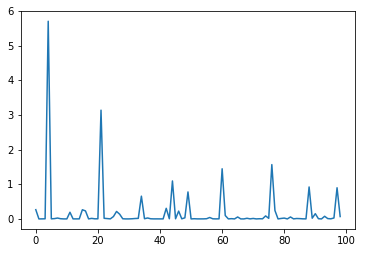

In [13]:
plt.plot(d_losses)

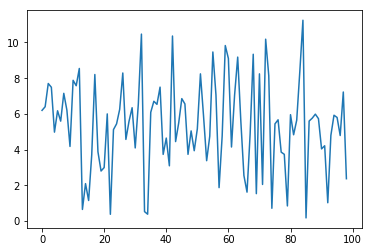

In [14]:
plt.plot(g_losses)

In [15]:
# Now we can train and test model on the generated data
synthentic_data

[tensor([[ 0.1541, -0.8050, -0.6093,  0.3721, -1.1224, -0.5287, -0.2201,
          -1.1745, -0.2593, -0.3773, -0.0005, -0.4323, -0.6013, -0.6770,
           0.5470,  0.4743, -0.7347, -0.2522, -1.5056, -0.8841, -0.1246,
          -1.3534,  1.5431,  0.8280,  1.2502, -0.8687,  0.1873,  0.4434,
          -0.8382,  0.6538]]),
 tensor([[-0.0019, -0.0309,  0.3246, -0.8050, -1.2943,  1.1473,  0.4631,
           0.7142, -1.1541, -0.7595,  0.9256, -0.3528, -0.8918,  0.9535,
          -1.1094, -0.7775, -0.9792,  1.2959,  1.1952,  0.3979, -1.0236,
           0.2086,  0.1225,  0.9802, -0.2037,  0.8815, -0.1194,  0.4633,
          -0.6676, -1.1684]]),
 tensor([[ 0.8780,  0.2278, -1.6239, -0.2630,  0.1067, -0.4418, -1.4109,
           0.5251, -0.8711,  1.9728,  0.7223, -0.8288,  0.1645,  0.4023,
          -0.3043, -0.5931,  0.6436,  0.0284,  0.0901, -0.0620,  1.0357,
          -0.1210,  1.5536,  0.6308, -1.5492,  1.1485,  1.5627, -0.2437,
          -1.3303, -0.2916]]),
 tensor([[-0.8346,  0.1855, -0.

In [16]:
# Convert array of tensor to tensors
temp = torch.Tensor(99)
synthentic_data = torch.cat(synthentic_data, out=temp)

In [18]:
# Convert tensor to PD data frame
synthentic_data_df = pd.DataFrame(data=synthentic_data.data.numpy());
synthentic_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.154058,-0.805023,-0.609287,0.372057,-1.122445,-0.528706,-0.220063,-1.174472,-0.259316,-0.377251,...,-0.124565,-1.353358,1.543099,0.827969,1.250208,-0.868746,0.187333,0.443387,-0.838185,0.653835
1,-0.001935,-0.030889,0.324551,-0.804980,-1.294312,1.147315,0.463092,0.714175,-1.154135,-0.759521,...,-1.023554,0.208640,0.122450,0.980193,-0.203689,0.881517,-0.119440,0.463349,-0.667569,-1.168444
2,0.878023,0.227793,-1.623895,-0.263034,0.106731,-0.441775,-1.410921,0.525050,-0.871109,1.972753,...,1.035683,-0.121034,1.553571,0.630789,-1.549194,1.148516,1.562665,-0.243722,-1.330347,-0.291580
3,-0.834613,0.185503,-0.387738,-0.113327,0.600975,0.253523,-0.407366,0.573156,1.559968,-1.287621,...,-0.306482,0.325508,-0.688057,0.459245,0.326428,0.325430,1.294043,-0.976792,0.148072,0.646601
4,-0.055959,1.192253,0.652752,0.143163,-0.259224,0.423089,1.088355,0.798973,-0.123981,0.963955,...,1.147442,-0.858664,0.834118,-1.109651,0.747253,-0.431315,-0.089733,0.806187,0.692386,-0.138840


In [19]:
synthentic_data_df.rename(columns={'0':'V1', '1':'V2', '2':'V3', '3':'V4', '4':'V5', '5':'V6', '6':'V7', '7':'V8', 
                                     '8':'V9', '9':'V10', '10':'V11', '11':'V12', '12':'V13', '13':'V14', '14':'V15', 
                                     '15':'V16', '16':'V17', '17':'V18', '18':'V19', '19':'V20', '20':'V21', '21':'V22',
                                     '22':'V23', '23':'V24', '24':'V25', '25':'V26', '26':'V27', '27':'V28', 
                                     '29':'normAmount', '30':'Class'}, inplace=True)

In [21]:
synthentic_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.154058,-0.805023,-0.609287,0.372057,-1.122445,-0.528706,-0.220063,-1.174472,-0.259316,-0.377251,...,-0.124565,-1.353358,1.543099,0.827969,1.250208,-0.868746,0.187333,0.443387,-0.838185,0.653835
1,-0.001935,-0.030889,0.324551,-0.804980,-1.294312,1.147315,0.463092,0.714175,-1.154135,-0.759521,...,-1.023554,0.208640,0.122450,0.980193,-0.203689,0.881517,-0.119440,0.463349,-0.667569,-1.168444
2,0.878023,0.227793,-1.623895,-0.263034,0.106731,-0.441775,-1.410921,0.525050,-0.871109,1.972753,...,1.035683,-0.121034,1.553571,0.630789,-1.549194,1.148516,1.562665,-0.243722,-1.330347,-0.291580
3,-0.834613,0.185503,-0.387738,-0.113327,0.600975,0.253523,-0.407366,0.573156,1.559968,-1.287621,...,-0.306482,0.325508,-0.688057,0.459245,0.326428,0.325430,1.294043,-0.976792,0.148072,0.646601
4,-0.055959,1.192253,0.652752,0.143163,-0.259224,0.423089,1.088355,0.798973,-0.123981,0.963955,...,1.147442,-0.858664,0.834118,-1.109651,0.747253,-0.431315,-0.089733,0.806187,0.692386,-0.138840
